<h1 style="line-height: 1.2; text-align: center;">DSBA-ML-Assignment_2</h1>

<p style="line-height: 1.2; text-align: center;">Alessandro Ivashkevich, Artur Garipov, Yuhong LI</p>

## Data Preparation & Exploratory Data Analysis (EDA)

### 1) Import necessary libraries, data

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score

from sklearn.metrics import f1_score

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import roc_curve

# import itertools
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset
# import random

from data_imputing import IterativeKNNImputer

# import warnings
# warnings.filterwarnings('ignore')  # early-stop warnings etc

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
# data = pd.read_csv('/content/drive/MyDrive/Assignment_2_FML_DSBA/train_dataset.csv', index_col=0)
data = pd.read_csv('train_dataset.csv', index_col=0)
data_test = pd.read_csv('test_dataset.csv', index_col=0)

In [8]:
print(data.head())
print(data.info())
print(data.describe())

     Age  Gender  Reviews_Read    Price  Discount  Category  Items_In_Cart  \
Id                                                                           
0   20.0     1.0           1.0  623.797      25.0       4.0            4.0   
1   22.0     0.0           5.0  549.324      50.0       4.0            8.0   
2   18.0     0.0           2.0  489.191      19.0       0.0            5.0   
3   25.0     0.0           3.0  769.450      16.0       4.0            5.0   
4   22.0     1.0           2.0   39.308      35.0       0.0            3.0   

   Time_of_Day  Email_Interaction Device_Type Payment_Method Referral_Source  \
Id                                                                             
0    afternoon                0.0     Desktop         PayPal          Direct   
1      evening                0.0     Desktop           Bank   Search_engine   
2    afternoon                0.0      Mobile           Bank           Email   
3      evening                0.0      Mobile        

### 2) Do categorical faetures initial encoding

In [9]:
# Define columns
numerical_cols = ['Age', 'Reviews_Read', 'Price', 'Discount', 'Items_In_Cart', 'Socioeconomic_Status_Score', 'Engagement_Score']
categorical_cols = ['Gender', 'Category', 'Time_of_Day', 'Email_Interaction', 'Device_Type', 'Payment_Method', 'Referral_Source']

In [10]:
# Check categorical features
print(data['Time_of_Day'].unique(), 
      data['Device_Type'].unique(), 
      data['Payment_Method'].unique(), 
      data['Referral_Source'].unique(), 
      sep='\n\n') 

['afternoon' 'evening' 'morning' 'eVening' 'afteRn00n' nan 'aftErNooN'
 'morNing' 'morninG' 'eveNing' 'evEninG' 'afteRnoon' 'aftern0on' 'morniNg'
 'Afternoon' 'Evening' 'eVEning' 'eveNiNg' 'evenIng' 'afterNoon' 'evenINg'
 'aftERnooN' 'm0RnIng' 'aFterNoon' 'afternoOn' 'afterno0n' 'eveninG'
 'afternO0n' 'afternOon' 'afternooN' 'm0rnIng' 'aFtErnO0n' 'evEniNg'
 'moRning' 'eveniNg']

['Desktop' 'Mobile' nan 'Tablet']

['PayPal' 'Bank' 'Credit' nan 'Cash' 'CreDit' 'BanK' 'BaNk' 'CaSh' 'CasH'
 'PayPaL' 'CrEdiT' 'PAyPaL' 'CAsh' 'CrEDit' 'PAyPal' 'CReDIt' 'PaYPal'
 'CrediT' 'CrEdit']

['Direct' 'Search_engine' 'Email' 'Social_media' nan 'Ads' 'SeArch_Engine'
 'SociaL_media' 'Search_eNgine' 'DiREcT' 'EMail' 'SociaL_medIa'
 'SoCial_meDia' 'EmaIl' 'SearCh_engine' 'DIrect' 'DireCt' 'AdS'
 'SeArch_engInE' 'SocIal_media' 'DirEct' 'Social_Media' 'SearCh_Engine'
 'S0cIaL_media' 'SeaRch_engine' 'SearcH_engiNe']


In [11]:
# Transform categorical columns
def categorical_transform(x):
  if not pd.isna(x):
    return str(x).lower().replace('0', 'o')

for col in categorical_cols:
  data[col] = data[col].apply(categorical_transform)
  data_test[col] = data_test[col].apply(categorical_transform)

print(data['Time_of_Day'].unique(),
      data_test['Time_of_Day'].unique(), 
      data['Device_Type'].unique(), 
      data_test['Device_Type'].unique(),
      data['Payment_Method'].unique(), 
      data_test['Payment_Method'].unique(),
      data['Referral_Source'].unique(), 
      data_test['Referral_Source'].unique(),
      sep='\n\n') 

['afternoon' 'evening' 'morning' None]

['afternoon' 'morning' 'evening' None]

['desktop' 'mobile' None 'tablet']

['mobile' 'tablet' 'desktop' None]

['paypal' 'bank' 'credit' None 'cash']

['cash' 'credit' 'paypal' 'bank' None]

['direct' 'search_engine' 'email' 'social_media' None 'ads']

['email' 'ads' 'search_engine' 'social_media' None 'direct']


In [12]:
# Custom LabelEncoder handling NaNs

le = LabelEncoder()
def label_encoder_with_nan(series):
    # Mask NaN values to temporarily handle only non-NaN
    non_null_values = series.dropna()
    le.fit(non_null_values)  

    return series.map(lambda x: le.transform([x])[0] if pd.notna(x) else np.nan)

In [13]:
# Apply data encoding

data_encoded = data.copy()
data_encoded_test = data_test.copy()
for col in categorical_cols:
    data_encoded[col] = label_encoder_with_nan(data_encoded[col])
    data_encoded_test[col] = label_encoder_with_nan(data_encoded_test[col])

# Sort by num then cat features
data_encoded = data_encoded[numerical_cols+categorical_cols]
data_encoded_test = data_encoded_test[numerical_cols+categorical_cols]
data_encoded

,Age,Reviews_Read,Price,Discount,Items_In_Cart,Socioeconomic_Status_Score,Engagement_Score,Gender,Category,Time_of_Day,Email_Interaction,Device_Type,Payment_Method,Referral_Source
Id,,,,,,,,,,,,,,
0,20.0,1.0,623.797,25.0,4.0,9.13,2.167873,0.0,3.0,0.0,1.0,0.0,3.0,1.0
1,22.0,5.0,549.324,50.0,8.0,9.53,3.494243,1.0,3.0,1.0,1.0,0.0,0.0,3.0
2,18.0,2.0,489.191,19.0,5.0,0.70,2.093568,1.0,4.0,0.0,1.0,1.0,0.0,2.0
3,25.0,3.0,769.450,16.0,5.0,6.83,3.644859,1.0,3.0,1.0,1.0,1.0,2.0,4.0
4,22.0,2.0,39.308,35.0,3.0,1.86,4.171256,0.0,4.0,1.0,1.0,1.0,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6495,31.0,4.0,316.049,7.0,2.0,3.47,5.034705,NaN,2.0,2.0,1.0,2.0,NaN,2.0
6496,NaN,6.0,58.784,25.0,1.0,5.24,1.726266,0.0,0.0,0.0,1.0,0.0,3.0,4.0
6497,19.0,5.0,373.853,46.0,5.0,4.16,0.411724,1.0,2.0,0.0,1.0,0.0,3.0,4.0


### 3) Handle missing values (if any)

In [14]:
# Checking for missing values
print("Missing values:\n", data_encoded.isnull().sum())

Missing values:
 Age                            970
Reviews_Read                   127
Price                          145
Discount                       124
Items_In_Cart                  141
Socioeconomic_Status_Score     120
Engagement_Score               135
Gender                         141
Category                       134
Time_of_Day                    129
Email_Interaction              127
Device_Type                    124
Payment_Method                1009
Referral_Source                997
dtype: int64


In [15]:
# Checking for missing values
print("Missing values:\n", data_encoded_test.isnull().sum())

Missing values:
 Age                           530
Reviews_Read                   73
Price                          55
Discount                       76
Items_In_Cart                  59
Socioeconomic_Status_Score     80
Engagement_Score               65
Gender                         59
Category                       66
Time_of_Day                    71
Email_Interaction              73
Device_Type                    76
Payment_Method                491
Referral_Source               503
dtype: int64


In [18]:
# Impute with My Knn - our custom class
iterative_imputer = IterativeKNNImputer(n_max_neighbors=80, epochs=4) # sqrt(6500)
data_imputed = iterative_imputer.impute(data_encoded, numerical_cols, categorical_cols)

iterative_imputer = IterativeKNNImputer(n_max_neighbors=59, epochs=4) # sqrt(3500)
data_imputed_test = iterative_imputer.impute(data_encoded_test, numerical_cols, categorical_cols)

Epoch 1 started
Epoch 1 finished
Epoch 2 started
Epoch 2 finished
Epoch 3 started
Epoch 3 finished
Epoch 4 started
Epoch 4 finished
Epoch 1 started
Epoch 1 finished
Epoch 2 started
Epoch 2 finished
Epoch 3 started
Epoch 3 finished
Epoch 4 started
Epoch 4 finished


In [19]:
# No missing values
data_imputed[data_imputed.isna().any(axis=1)]

,Age,Reviews_Read,Price,Discount,Items_In_Cart,Socioeconomic_Status_Score,Engagement_Score,Gender,Category,Time_of_Day,Email_Interaction,Device_Type,Payment_Method,Referral_Source
Id,,,,,,,,,,,,,,


### 4) Preprocess numerical data, observe distribution of categorical features

#### Numerical data preprocessing

In [20]:
data_imputed_full = pd.concat([data_imputed, data['Purchase']], axis=1)
data_imputed_full

,Age,Reviews_Read,Price,Discount,Items_In_Cart,Socioeconomic_Status_Score,Engagement_Score,Gender,Category,Time_of_Day,Email_Interaction,Device_Type,Payment_Method,Referral_Source,Purchase
Id,,,,,,,,,,,,,,,
0,20.000000,1.0,623.797,25.0,4.0,9.13,2.167873,0.0,3.0,0.0,1.0,0.0,3.0,1.0,0
1,22.000000,5.0,549.324,50.0,8.0,9.53,3.494243,1.0,3.0,1.0,1.0,0.0,0.0,3.0,0
2,18.000000,2.0,489.191,19.0,5.0,0.70,2.093568,1.0,4.0,0.0,1.0,1.0,0.0,2.0,0
3,25.000000,3.0,769.450,16.0,5.0,6.83,3.644859,1.0,3.0,1.0,1.0,1.0,2.0,4.0,0
4,22.000000,2.0,39.308,35.0,3.0,1.86,4.171256,0.0,4.0,1.0,1.0,1.0,2.0,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6495,31.000000,4.0,316.049,7.0,2.0,3.47,5.034705,0.0,2.0,2.0,1.0,2.0,0.0,2.0,1
6496,37.001186,6.0,58.784,25.0,1.0,5.24,1.726266,0.0,0.0,0.0,1.0,0.0,3.0,4.0,0
6497,19.000000,5.0,373.853,46.0,5.0,4.16,0.411724,1.0,2.0,0.0,1.0,0.0,3.0,4.0,0


In [21]:
# Correlation analysis on numerical columns
corr_matrix = data_imputed_full.drop(categorical_cols, axis=1).corr()
corr_matrix['Purchase'].sort_values(ascending=False)

# we see some little correlation - maybe reduction of number of features is a good idea. Will check PCA

Purchase                      1.000000
Discount                      0.106891
Reviews_Read                  0.080311
Socioeconomic_Status_Score    0.036943
Engagement_Score              0.032962
Age                          -0.002958
Items_In_Cart                -0.093124
Price                        -0.172018
Name: Purchase, dtype: float64

In [22]:
# Correlation cat on categorical columns
corr_matrix = data_imputed_full.drop(numerical_cols, axis=1).corr()
corr_matrix['Purchase'].sort_values(ascending=False)

# we see some little correlation - maybe reduction of number of features is a good idea. Will check PCA

Purchase             1.000000
Gender               0.138922
Device_Type          0.059433
Time_of_Day          0.031289
Payment_Method       0.007739
Referral_Source      0.002946
Category            -0.029888
Email_Interaction   -0.414281
Name: Purchase, dtype: float64

In [16]:
# Feature combination
# Create ratios Engagement_Score / Items_In_Cart,Discount / Price, Reviews_Read / Engagement_Score, Price / Socioeconomic_Status_Score, Engagement_Score / Socioeconomic_Status_Score
# data_imputed_full['Engagement_Score_Items_In_Cart'] = data_imputed_full['Engagement_Score'] / data_imputed_full['Items_In_Cart']
# data_imputed_full['Discount_ratio'] = data_imputed_full['Discount'] / data_imputed_full['Price']
# data_imputed_full['Reviews_Read_Engagement_Score'] = data_imputed_full['Reviews_Read'] / data_imputed_full['Engagement_Score']
# data_imputed_full['Price_Socioeconomic_Status_Score'] = data_imputed_full['Price'] / data_imputed_full['Socioeconomic_Status_Score']
# data_imputed_full['Engagement_Score_Socioeconomic_Status_Score'] = data_imputed_full['Engagement_Score'] / data_imputed_full['Socioeconomic_Status_Score']

# numerical_cols.extend(['Engagement_Score_Items_In_Cart', 'Discount_Price', 'Reviews_Read_Engagement_Score', 'Price_Socioeconomic_Status_Score', 'Engagement_Score_Socioeconomic_Status_Score'])
# data_imputed_full.describe()

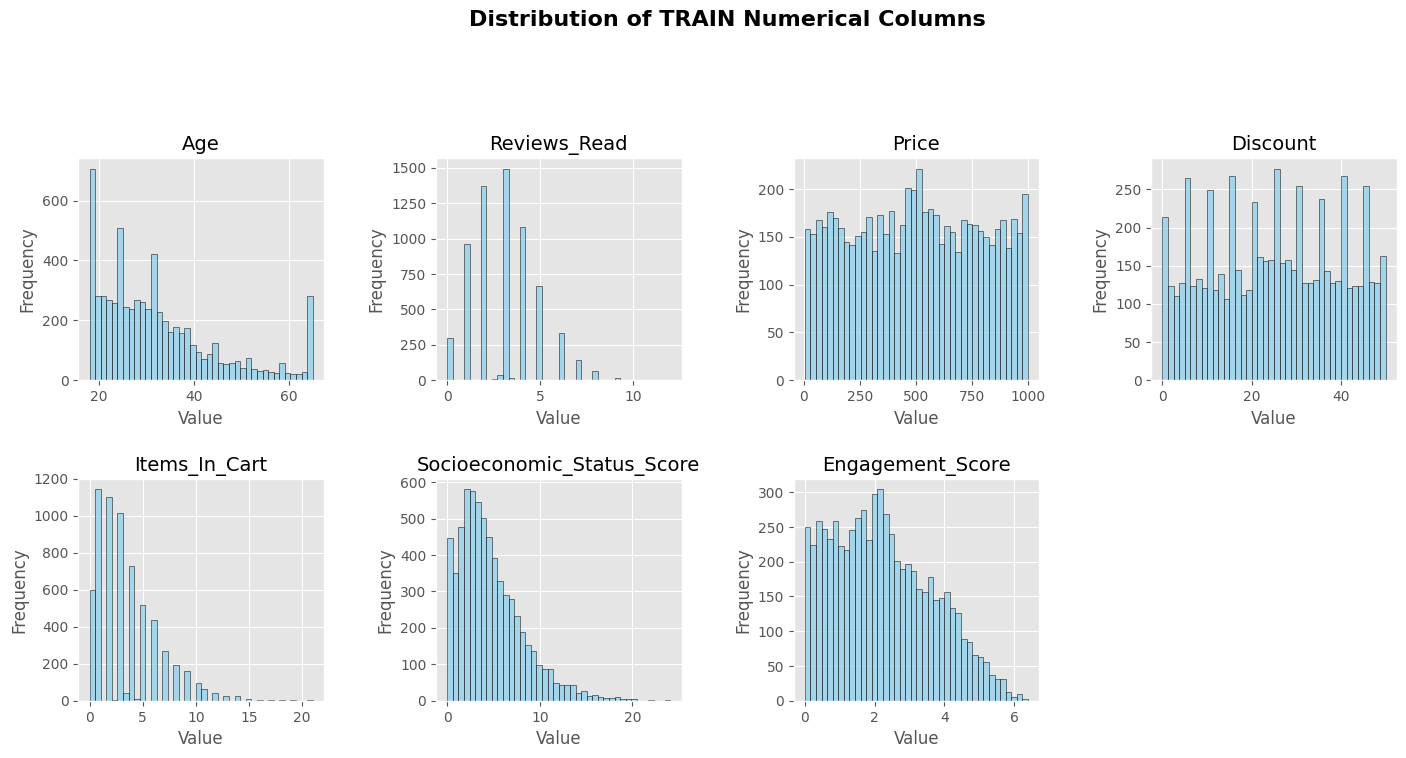

In [23]:
### TRAIN DATA

# Set a consistent style for better aesthetics
plt.style.use('ggplot')

# Create the subplots with adjusted spacing
fig, axs = plt.subplots(2, 4, figsize=(15, 8))
fig.suptitle('Distribution of TRAIN Numerical Columns', fontsize=16, fontweight='bold')
fig.tight_layout(pad=5.0)

# Iterate through columns and create histograms
for i, col in enumerate(numerical_cols):
    row, col_idx = divmod(i, 4)  # Determine subplot position
    axs[row, col_idx].hist(data_imputed_full[col], bins=40, color='skyblue', edgecolor='black', alpha=0.7) #data[col].dropna()
    axs[row, col_idx].set_title(col, fontsize=14)
    axs[row, col_idx].set_xlabel('Value', fontsize=12)
    axs[row, col_idx].set_ylabel('Frequency', fontsize=12)

# Remove any empty subplots
for j in range(len(numerical_cols), 8):
    row, col_idx = divmod(j, 4)
    fig.delaxes(axs[row, col_idx])

# Display the plots
plt.show()

In [24]:
# Transform data
data_transformed = data_imputed_full.copy()
data_transformed['Engagement_Score'] = data_transformed['Engagement_Score'].apply(lambda x: np.sqrt(x))
data_transformed['Reviews_Read'] = data_transformed['Reviews_Read'].apply(lambda x: np.sqrt(x))
data_transformed['Age'] = data_transformed['Age'].apply(lambda x: 1/(x+0.1))

data_transformed['Items_In_Cart'] = data_transformed['Items_In_Cart'].apply(lambda x: np.log2(x + 1))
data_transformed['Socioeconomic_Status_Score'] = data_transformed['Socioeconomic_Status_Score'].apply(lambda x: np.log2(x + 1))

# Transform data_test
data_transformed_test = data_imputed_test.copy()
data_transformed_test['Engagement_Score'] = data_transformed_test['Engagement_Score'].apply(lambda x: np.sqrt(x))
data_transformed_test['Reviews_Read'] = data_transformed_test['Reviews_Read'].apply(lambda x: np.sqrt(x))
data_transformed_test['Age'] = data_transformed_test['Age'].apply(lambda x: 1/(x+0.1))

data_transformed_test['Items_In_Cart'] = data_transformed_test['Items_In_Cart'].apply(lambda x: np.log2(x + 1))
data_transformed_test['Socioeconomic_Status_Score'] = data_transformed_test['Socioeconomic_Status_Score'].apply(lambda x: np.log2(x + 1))

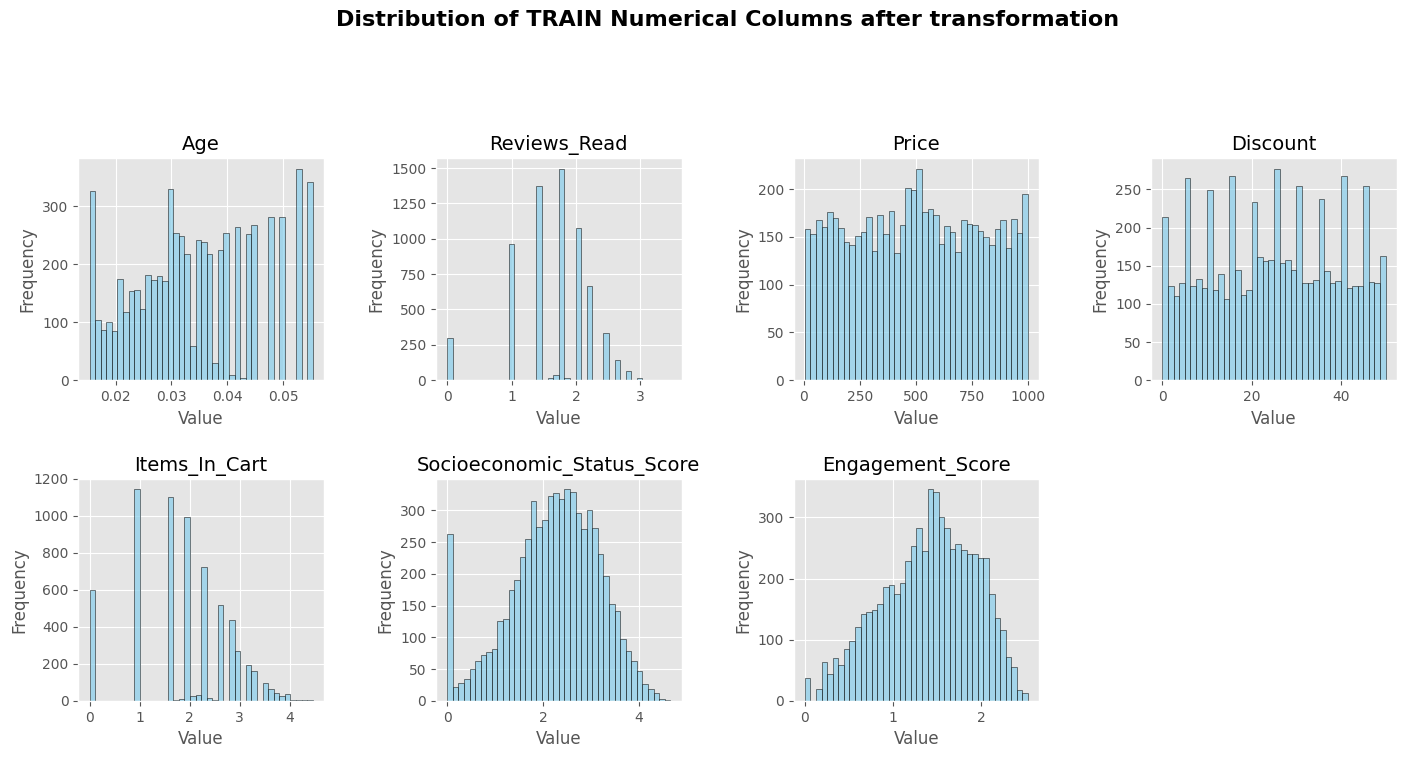

In [25]:
### TRAIN DATA

# Set a consistent style for better aesthetics
plt.style.use('ggplot')

# Create the subplots with adjusted spacing
fig, axs = plt.subplots(2, 4, figsize=(15, 8))
fig.suptitle('Distribution of TRAIN Numerical Columns after transformation', fontsize=16, fontweight='bold')
fig.tight_layout(pad=5.0)

# Iterate through columns and create histograms
for i, col in enumerate(numerical_cols):
    row, col_idx = divmod(i, 4)  # Determine subplot position
    axs[row, col_idx].hist(data_transformed[col], bins=40, color='skyblue', edgecolor='black', alpha=0.7) #data[col].dropna()
    axs[row, col_idx].set_title(col, fontsize=14)
    axs[row, col_idx].set_xlabel('Value', fontsize=12)
    axs[row, col_idx].set_ylabel('Frequency', fontsize=12)

# Remove any empty subplots
for j in range(len(numerical_cols), 8):
    row, col_idx = divmod(j, 4)
    fig.delaxes(axs[row, col_idx])

# Display the plots
plt.show()

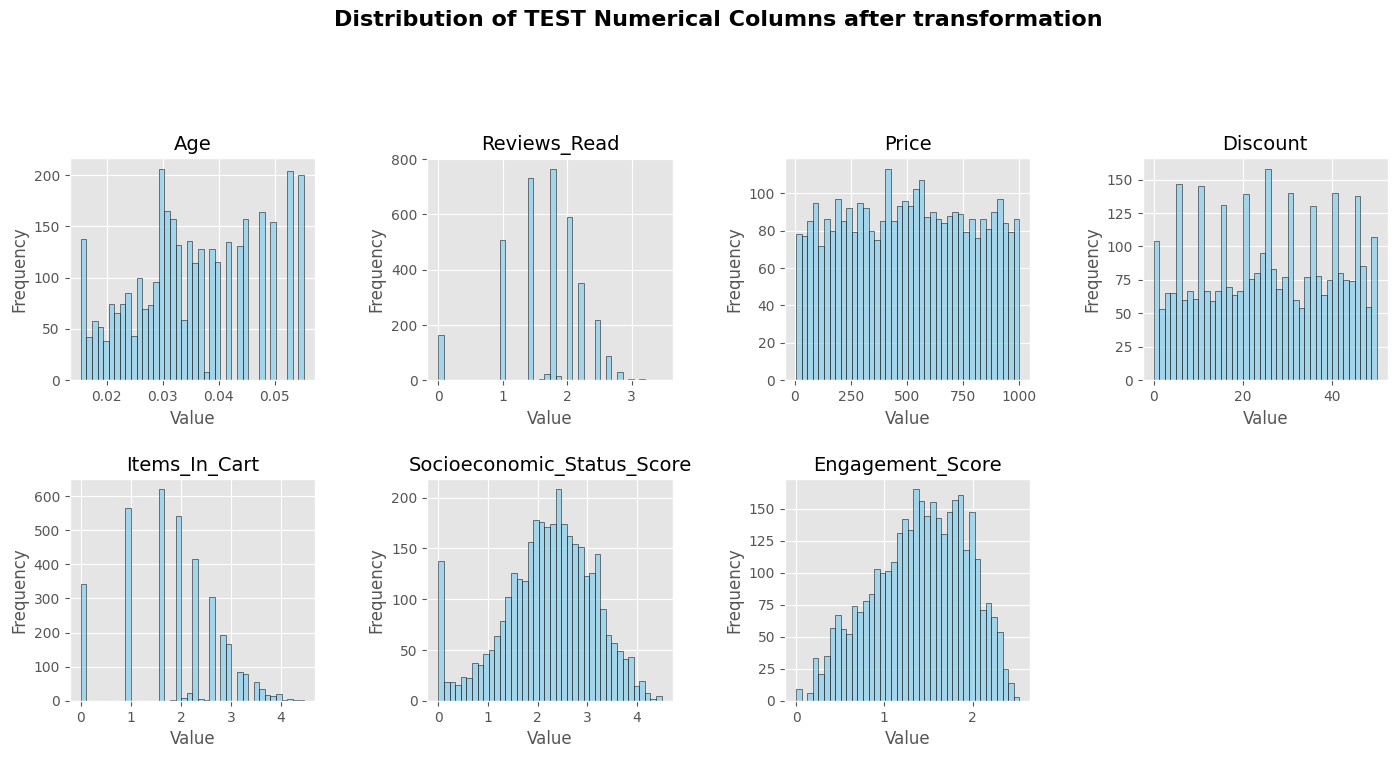

In [26]:
### TEST DATA

# Set a consistent style for better aesthetics
plt.style.use('ggplot')

# Create the subplots with adjusted spacing
fig, axs = plt.subplots(2, 4, figsize=(15, 8))
fig.suptitle('Distribution of TEST Numerical Columns after transformation', fontsize=16, fontweight='bold')
fig.tight_layout(pad=5.0)

# Iterate through columns and create histograms
for i, col in enumerate(numerical_cols):
    row, col_idx = divmod(i, 4)  # Determine subplot position
    axs[row, col_idx].hist(data_transformed_test[col], bins=40, color='skyblue', edgecolor='black', alpha=0.7) #data[col].dropna()
    axs[row, col_idx].set_title(col, fontsize=14)
    axs[row, col_idx].set_xlabel('Value', fontsize=12)
    axs[row, col_idx].set_ylabel('Frequency', fontsize=12)

# Remove any empty subplots
for j in range(len(numerical_cols), 8):
    row, col_idx = divmod(j, 4)
    fig.delaxes(axs[row, col_idx])

# Display the plots
plt.show()

#### Categorical data preprocessing

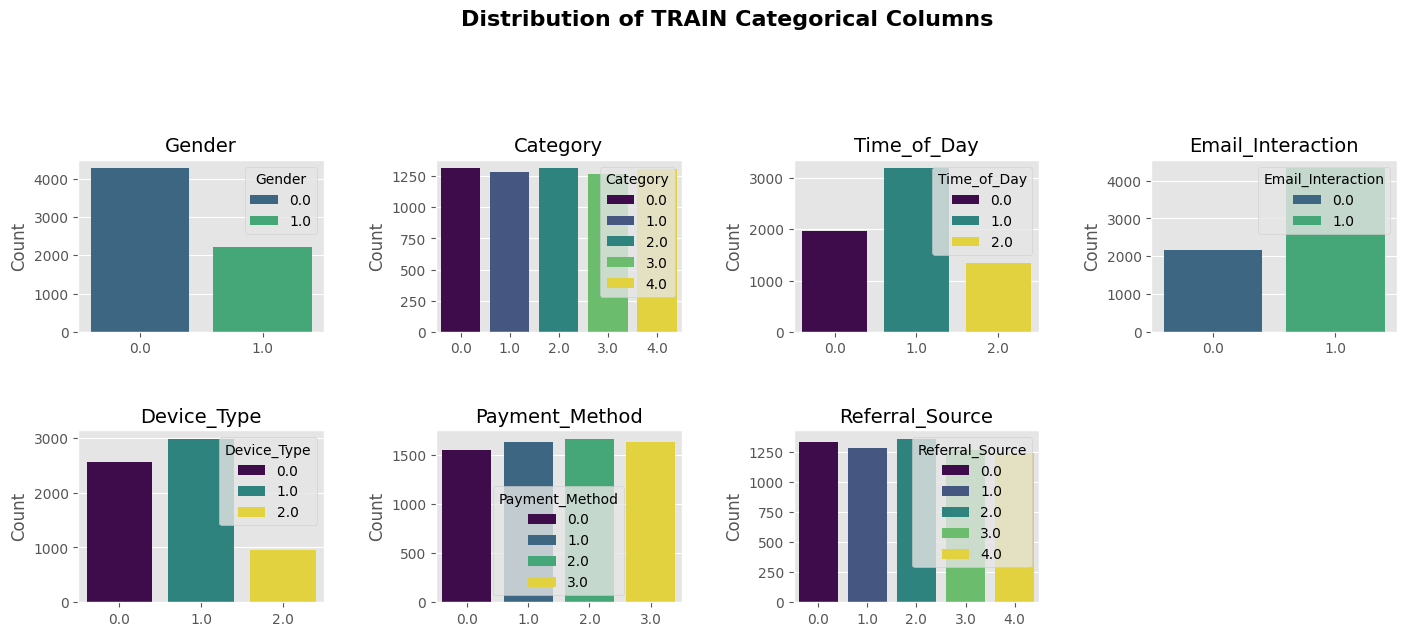

In [27]:
### TRAIN DATA

# Create the subplots with adjusted spacing
fig, axs = plt.subplots(2, 4, figsize=(15, 7))
fig.suptitle('Distribution of TRAIN Categorical Columns', fontsize=16, fontweight='bold')
fig.tight_layout(pad=5.0)

# Iterate through columns and create count plots
for i, col in enumerate(categorical_cols):
    row, col_idx = divmod(i, 4)  # Determine subplot position
    sns.countplot(x=col, data=data_transformed, ax=axs[row, col_idx], palette='viridis', hue=f'{col}')
    axs[row, col_idx].set_title(col, fontsize=14)
    axs[row, col_idx].set_xlabel(None)
    axs[row, col_idx].set_ylabel('Count', fontsize=12)

# Remove any empty subplots
for j in range(len(categorical_cols), 8):
    row, col_idx = divmod(j, 4)
    fig.delaxes(axs[row, col_idx])

# Display the plots
plt.show()

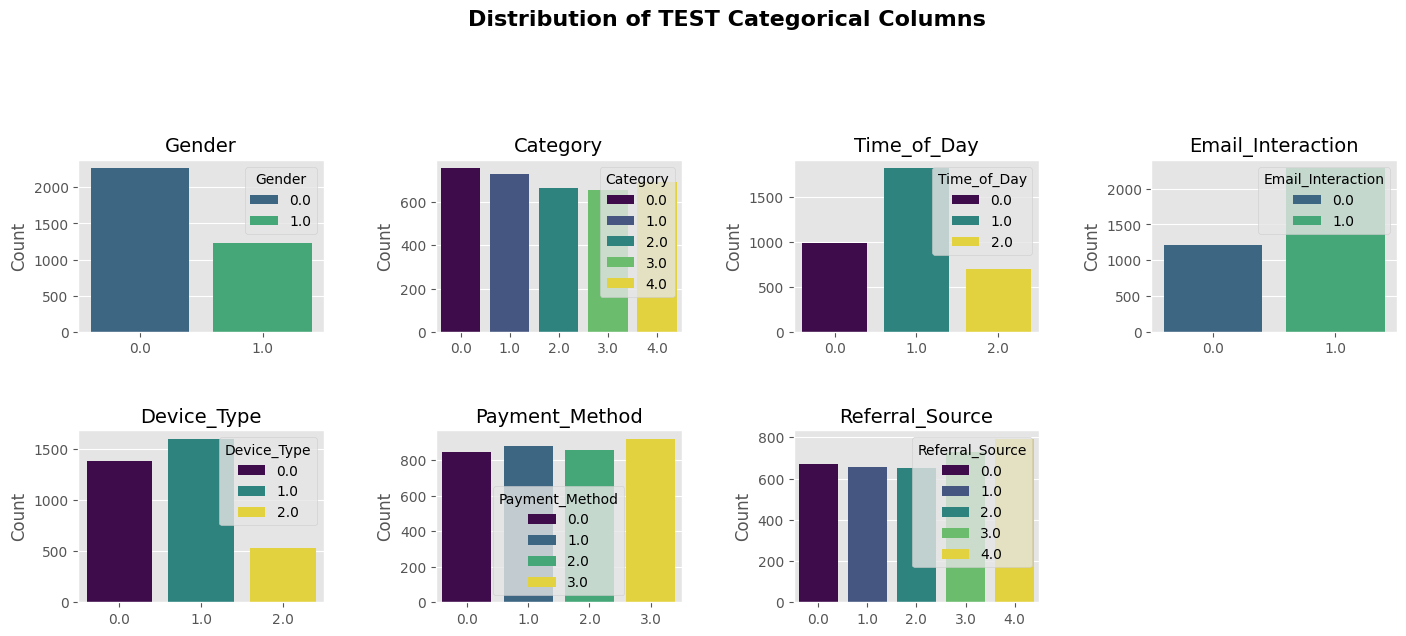

In [28]:
### TEST DATA

# Create the subplots with adjusted spacing
fig, axs = plt.subplots(2, 4, figsize=(15, 7))
fig.suptitle('Distribution of TEST Categorical Columns', fontsize=16, fontweight='bold')
fig.tight_layout(pad=5.0)

# Iterate through columns and create count plots
for i, col in enumerate(categorical_cols):
    row, col_idx = divmod(i, 4)  # Determine subplot position
    sns.countplot(x=col, data=data_transformed_test, ax=axs[row, col_idx], palette='viridis', hue=f'{col}')
    axs[row, col_idx].set_title(col, fontsize=14)
    axs[row, col_idx].set_xlabel(None)
    axs[row, col_idx].set_ylabel('Count', fontsize=12)

# Remove any empty subplots
for j in range(len(categorical_cols), 8):
    row, col_idx = divmod(j, 4)
    fig.delaxes(axs[row, col_idx])

# Display the plots
plt.show()

## Feature Selection

### 5) Splitting the data into train, test and target. Check balance of classes. Do data standartization

In [29]:
X = data_transformed.drop(columns='Purchase')
y = data_transformed['Purchase']

X_target = data_transformed_test.copy()

In [30]:
# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, test_size=0.2, random_state=42)

#### balance of classes

In [31]:
y_train.value_counts(), y.value_counts()

(Purchase
 0    3280
 1    1920
 Name: count, dtype: int64,
 Purchase
 0    4100
 1    2400
 Name: count, dtype: int64)

In [ ]:
# Oversample data
# ! But !
# Found out, that setting class weights works better
from imblearn.over_sampling import SMOTENC

#categorical_columns_indecies = [X_train.columns.get_loc(col) for col in categorical_cols]
#k_n = int(np.sqrt(X_train.shape[0]))
#smote_nc = SMOTENC(categorical_features = categorical_columns_indecies, k_neighbors = k_n, random_state=42)
#X_train, y_train = smote_nc.fit_resample(X_train, y_train)

#categorical_columns_indecies = [X.columns.get_loc(col) for col in categorical_cols]
#k_n = int(np.sqrt(X.shape[0]))
#smote_nc = SMOTENC(categorical_features = categorical_columns_indecies, k_neighbors = k_n, random_state=42)
#X, y = smote_nc.fit_resample(X, y)

In [55]:
# One hot encoding
X_train = pd.get_dummies(X_train, columns=categorical_cols)
X_test = pd.get_dummies(X_test, columns=categorical_cols)
X = pd.get_dummies(X, columns=categorical_cols)
X_target = pd.get_dummies(X_target, columns=categorical_cols)

X_train = X_train.replace({True: 1.0, False: 0.0})
X_test = X_test.replace({True: 1.0, False: 0.0})
X = X.replace({True: 1.0, False: 0.0})
X_target = X_target.replace({True: 1.0, False: 0.0})

categorical_cols_ohe = [i for i in X_train.columns.tolist() if (i not in numerical_cols) and (i != 'Purchase')]

In [56]:
# Standartize data
for col in X_train.columns.tolist():
    X_train[col] = (X_train[col] - X_train[col].mean()) / X_train[col].std()
    X_test[col] = (X_test[col] - X_test[col].mean()) / X_test[col].std()
    X[col] = (X[col] - X[col].mean()) / X[col].std()
    X_target[col] = (X_target[col] - X_target[col].mean()) / X_target[col].std()

In [57]:
# Handle outliers (if any)
def cap_outliers(data, lower_percentile, upper_percentile):
    # Convert data to a Pandas Series for easier manipulation
    data = pd.Series(data)
    
    # Calculate the lower and upper bounds
    lower_bound = np.percentile(data, lower_percentile)
    upper_bound = np.percentile(data, upper_percentile)
    
    # Cap the outliers
    capped_data = data.clip(lower=lower_bound, upper=upper_bound)
    
    return capped_data, lower_bound, upper_bound

In [58]:
# Cap outliers
for col in numerical_cols:
    X_train[col] = cap_outliers(X_train[col], lower_percentile=2.5, upper_percentile=97.5)[0]
    X_test[col] = cap_outliers(X_test[col], lower_percentile=2.5, upper_percentile=97.5)[0]
    X[col] = cap_outliers(X[col], lower_percentile=2.5, upper_percentile=97.5)[0]
    X_target[col] = cap_outliers(X_target[col], lower_percentile=2.5, upper_percentile=97.5)[0]    

### 6) Feature selection with PCA

In [28]:
# TRAIN-TEST DATA

pca_full = PCA()
pca_full.fit(X_train)

# Determine how many components are required for 80% explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# np.searchsorted(cumulative_variance, 0.80) returns the first index where the cumulative variance reaches or exceeds 80%
n_components_80 = np.searchsorted(cumulative_variance, 0.80) + 1

print(f"Number of components to cover 80% variance: {n_components_80}")

# Refit PCA with the exact number of components
pca = PCA(n_components=n_components_80)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


Number of components to cover 80% variance: 18


In [29]:
# ALL DATA

pca_full = PCA()
pca_full.fit(X)

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

n_components_80 = np.searchsorted(cumulative_variance, 0.80) + 1

print(f"Number of components to cover 80% variance: {n_components_80}")

pca = PCA(n_components=n_components_80)
X_pca = pca.fit_transform(X)
X_target_pca = pca.transform(X_target)


Number of components to cover 80% variance: 18


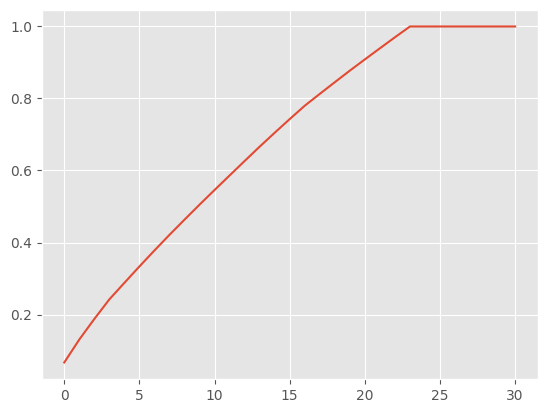

In [30]:
# components variance explanation
pca_full.explained_variance_ratio_
# components sum
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))

## Model Estimation

### 7) Fit several classic ML models on train-test data. Compare their scores. Assess PCA usefulness

In [31]:
zeros, ones = y_train.value_counts()
print(f'0: {zeros}, 1: {ones}')
class_weights = {0: 1.0, 1: np.round(zeros/ones, 3)}
class_weights 

0: 3280, 1: 1920


{0: 1.0, 1: 1.708}

In [49]:
# For PCA 80%

# 1) Common Cross-Validation & Scorer

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_macro_scorer = make_scorer(f1_score, average='macro')

# 2) Define the Models & Param Grids (same for both approaches)

models_and_grids = [
    (
        LogisticRegression(max_iter=10000, random_state=42, class_weight={0: 1.0, 1: 2.0}),
        {'C': [0.001, 0.01, 0.1, 1, 10, 100]},
        "Logistic Regression"
    ),
    (
        SVC(kernel='linear', max_iter=10000, random_state=42, class_weight={0: 1.0, 1: 2.0}),
        {'C': [0.001, 0.01, 0.1, 1, 10, 100]},
        "Linear SVC"
    ),
    (
        SVC(kernel='rbf', random_state=42, class_weight={0: 1.0, 1: 2.0}),
        {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'gamma': [0.001, 0.01, 0.1, 10, 100]
        },
        "RBF SVC"
    ),
    (
        RandomForestClassifier(random_state=42, class_weight={0: 1.0, 1: 2.0}),
        {
            'n_estimators': [10, 30, 60, 100, 200],
            'max_depth': [None, 1, 3, 6, 10, 20]
        },
        "Random Forest"
    ),
    (
        AdaBoostClassifier(RandomForestClassifier(max_depth=3, n_estimators=200, random_state=42, class_weight={0: 1.0, 1: 2.0}), random_state=42),
        {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 1]
        },
        "AdaBoost"
    )
]

##############################################################################
# 3) Approach A: No PCA
##############################################################################
print("=== Approach A: No PCA ===\n")
best_models_no_pca = {}
for model, param_grid, name in models_and_grids:
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=f1_macro_scorer,
        cv=cv,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    best_models_no_pca[name] = grid_search.best_estimator_

    print(f"{name} best params: {grid_search.best_params_}")
    print(f"{name} CV best F1 (macro): {grid_search.best_score_:.4f}\n")

# Evaluate Approach A on the test set
test_scores_no_pca = {}
for name, model in best_models_no_pca.items():
    y_pred = model.predict(X_test)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    test_scores_no_pca[name] = f1_macro

print("Test results (No PCA):")
for name, score in test_scores_no_pca.items():
    print(f"{name}: F1(macro) = {score:.4f}")
print("--------------------------------------------------------\n")

##############################################################################
# 4) Approach B: With PCA (selecting enough components for ~80% variance)
##############################################################################

##############################################################################
# 5) Final Comparison: No PCA vs. With PCA
##############################################################################
print("=== Final Comparison on Test Set ===")
for name in best_models_no_pca.keys():
    score_no_pca = test_scores_no_pca[name]
    # score_pca = test_scores_pca[name]
    print(
        f"{name}\n"
        f"  -> No PCA:   F1(macro)={score_no_pca:.4f}\n"
        # f"  -> With PCA: F1(macro)={score_pca:.4f}\n"
    )

=== Approach A: No PCA ===

Logistic Regression best params: {'C': 0.01}
Logistic Regression CV best F1 (macro): 0.7129

Linear SVC best params: {'C': 0.01}
Linear SVC CV best F1 (macro): 0.7212

RBF SVC best params: {'C': 10, 'gamma': 0.001}
RBF SVC CV best F1 (macro): 0.7178

Random Forest best params: {'max_depth': 10, 'n_estimators': 200}
Random Forest CV best F1 (macro): 0.7237



D:\Python\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost best params: {'learning_rate': 0.1, 'n_estimators': 100}
AdaBoost CV best F1 (macro): 0.7242

Test results (No PCA):
Logistic Regression: F1(macro) = 0.7219
Linear SVC: F1(macro) = 0.7272
RBF SVC: F1(macro) = 0.7299
Random Forest: F1(macro) = 0.7465
AdaBoost: F1(macro) = 0.7397
--------------------------------------------------------

=== Final Comparison on Test Set ===
Logistic Regression
  -> No PCA:   F1(macro)=0.7219

Linear SVC
  -> No PCA:   F1(macro)=0.7272

RBF SVC
  -> No PCA:   F1(macro)=0.7299

Random Forest
  -> No PCA:   F1(macro)=0.7465

AdaBoost
  -> No PCA:   F1(macro)=0.7397



In [193]:
# Select best model and best thresholds
our_model = best_models_no_pca["AdaBoost"]
our_model_fitted = our_model.fit(X_train, y_train)

D:\Python\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [194]:
from sklearn.metrics import roc_curve

y_probs_train = our_model_fitted.predict_proba(X_train)[:, 1]
y_probs = our_model_fitted.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_probs_train)

optimal_threshold = thresholds[np.argmax(tpr - fpr)]
y_pred = (y_probs >= optimal_threshold).astype(int)

In [195]:
# y_pred = our_model.predict(X_test)
print("F1 Score: ", f1_score(y_test, y_pred, average='macro'))
print("Classification Report:\n", classification_report(y_test, y_pred))

F1 Score:  0.7475513103527767
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.79      0.81       820
           1       0.67      0.71      0.69       480

    accuracy                           0.76      1300
   macro avg       0.74      0.75      0.75      1300
weighted avg       0.77      0.76      0.76      1300



## Training Model on all training dataset

### 8) Choose best model from CV and train it

In [33]:
# For PCA 80%

# 1) Common Cross-Validation & Scorer

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_macro_scorer = make_scorer(f1_score, average='macro')

# 2) Define the Models & Param Grids (same for both approaches)

models_and_grids = [
    (
        RandomForestClassifier(random_state=42),
        {
            'n_estimators': [10, 30, 60, 100, 200],
            'max_depth': [None, 1, 3, 6, 10, 20]
        },
        "Random Forest"
    ),
    (
        AdaBoostClassifier(RandomForestClassifier(random_state=42, class_weight={0: 1.0, 1: 2.0}), random_state=42),
        {
            'estimator__n_estimators': [50, 100, 150],
            'estimator__max_depth': [None, 10, 20],
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 1.0],
        },
        "AdaBoost"
    )
]


##############################################################################
# 3) Approach A: No PCA
##############################################################################
print("=== Approach A: No PCA ===\n")

test_scores_no_pca = {}
best_models_no_pca = {}
for model, param_grid, name in models_and_grids:
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=f1_macro_scorer,
        cv=cv,
        n_jobs=-1
    )
    grid_search.fit(X, y)
    best_models_no_pca[name] = grid_search.best_estimator_

    print(f"{name} best params: {grid_search.best_params_}")
    print(f"{name} CV best F1 (macro): {grid_search.best_score_:.4f}\n")
    
    test_scores_no_pca[name] = grid_search.best_score_    

print("--------------------------------------------------------\n")

##############################################################################
# 4) Approach B: With PCA (selecting enough components for ~80% variance)
##############################################################################

##############################################################################
# 5) Final Comparison: No PCA vs. With PCA
##############################################################################
print("=== Final Comparison on Test Set ===")
for name in best_models_no_pca.keys():
    score_no_pca = test_scores_no_pca[name]
    # score_pca = test_scores_pca[name]
    print(
        f"{name}\n"
        f"  -> No PCA:   CV best F1 (macro)={score_no_pca:.4f}\n"
        # f"  -> With PCA: CV best F1 (macro)={score_pca:.4f}\n"·
    )

=== Approach A: No PCA ===

Random Forest best params: {'max_depth': 20, 'n_estimators': 200}
Random Forest CV best F1 (macro): 0.7196



D:\Python\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost best params: {'estimator__max_depth': 10, 'estimator__n_estimators': 100, 'learning_rate': 0.01, 'n_estimators': 200}
AdaBoost CV best F1 (macro): 0.7306

--------------------------------------------------------

=== Final Comparison on Test Set ===
Random Forest
  -> No PCA:   CV best F1 (macro)=0.7196

AdaBoost
  -> No PCA:   CV best F1 (macro)=0.7306



In [34]:
# Select best model and best thresholds
our_model = best_models_no_pca["AdaBoost"]
our_model_fitted = our_model.fit(X_train, y_train)

D:\Python\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [35]:
from sklearn.metrics import roc_curve

y_probs_train = our_model_fitted.predict_proba(X_train)[:, 1]
y_probs = our_model_fitted.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_probs_train)

optimal_threshold = thresholds[np.argmax(tpr - fpr)]
y_pred = (y_probs >= optimal_threshold).astype(int)

In [36]:
# y_pred = our_model.predict(X_test)
print("F1 Score: ", f1_score(y_test, y_pred, average='macro'))
print("Classification Report:\n", classification_report(y_test, y_pred))

F1 Score:  0.7446103175410326
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.80      0.81       820
           1       0.67      0.69      0.68       480

    accuracy                           0.76      1300
   macro avg       0.74      0.75      0.74      1300
weighted avg       0.76      0.76      0.76      1300



# Final Submission

In [37]:
# our_model =  AdaBoostClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
our_model = best_models_no_pca["AdaBoost"]
fitted_model = our_model.fit(X, y)

D:\Python\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [38]:
from sklearn.metrics import roc_curve

y_probs_X = our_model.predict_proba(X)[:, 1]
y_probs_target = our_model.predict_proba(X_target)[:, 1]
fpr, tpr, thresholds = roc_curve(y, y_probs_X)

optimal_threshold = thresholds[np.argmax(tpr - fpr)]
y_pred_target = (y_probs_target >= optimal_threshold).astype(int)

In [39]:
# evaluation_predictions = fitted_model.predict(X_target)

predictions_df = pd.DataFrame({
    'Id': X_target.index,
    'Purchase': y_pred_target
})

predictions_df.to_csv('purchase_predictions_eval.csv', index=False)
print("Predictions saved to 'purchase_predictions_eval.csv'")

Predictions saved to 'purchase_predictions_eval.csv'


In [40]:
predictions_df

,Id,Purchase
0,6500,0
1,6501,1
2,6502,1
3,6503,0
4,6504,0
...,...,...
3495,9995,1
3496,9996,1
3497,9997,0
3498,9998,1


## Train NN

In [59]:
# Define the Neural Network class
class BinaryClassificationNN(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_fn, dropout_rate):
        super(BinaryClassificationNN, self).__init__()
        layers = []
        current_size = input_size
        
        for layer_size in hidden_layers:
            layers.append(nn.Linear(current_size, layer_size))
            layers.append(activation_fn())
            layers.append(nn.Dropout(dropout_rate))
            current_size = layer_size
        
        layers.append(nn.Linear(current_size, 1))
        layers.append(nn.Sigmoid())
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [60]:
# Cross-validation function with Stratified K-Fold and optimal threshold
def stratified_cross_validate_nn_with_optimal_threshold(X_train, y_train, param_grid, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    results = []
    
    for params in itertools.product(*param_grid.values()):
        config = dict(zip(param_grid.keys(), params))
        # print(f"Testing config: {config}")
        
        f1_scores = []
        for train_index, val_index in skf.split(X_train, y_train):
            # Split data
            X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
            y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
            
            # Convert to tensors
            X_fold_train_tensor = torch.tensor(X_fold_train, dtype=torch.float32).to(device)
            y_fold_train_tensor = torch.tensor(y_fold_train, dtype=torch.float32).to(device)
            X_fold_val_tensor = torch.tensor(X_fold_val, dtype=torch.float32).to(device)
            y_fold_val_tensor = torch.tensor(y_fold_val, dtype=torch.float32).to(device)
            
            # Create model
            model = BinaryClassificationNN(
                input_size=X_train.shape[1],
                hidden_layers=config["hidden_layers"],
                activation_fn=config["activation_fn"],
                dropout_rate=config["dropout_rate"]
            ).to(device)
            
            optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
            # criterion = nn.BCELoss()
            train_dataset = TensorDataset(X_fold_train_tensor, y_fold_train_tensor)
            train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
            
            # Train the model
            model.train()
            for epoch in range(config["epochs"]):
                for batch_X, batch_y in train_loader:
                    # Move data to GPU
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                    weights = batch_y.cpu().numpy()
                    weight_for_ones = weights[weights==0].shape[0] / weights[weights==1].shape[0]
                    weight_for_zeros = 1
                    weights[weights==1] = weight_for_ones 
                    weights[weights==0] = weight_for_zeros
                    weights = torch.tensor(weights).to(device)
                    # weights = None

                    # Forward pass
                    optimizer.zero_grad()
                    predictions = model(batch_X).squeeze()  # Get predictions
                    loss = nn.BCELoss(weight=weights)(predictions, batch_y)
                    #loss = criterion(predictions, batch_y)
                    loss.backward()
                    optimizer.step()
            
            # Validate the model
            model.eval()
            with torch.no_grad():
                y_probs_X_train = model(X_fold_train_tensor).squeeze()
                y_probs_X_test = model(X_fold_val_tensor).squeeze()
                
                # Compute ROC curve and find optimal threshold
                fpr, tpr, thresholds = roc_curve(y_fold_train_tensor.cpu().numpy(), y_probs_X_train.cpu().numpy())
                optimal_threshold = thresholds[np.argmax(tpr - fpr)]
                # print(f"Optimal Threshold: {optimal_threshold:.4f}")
                
                # Apply optimal threshold
                val_predictions = (y_probs_X_test >= optimal_threshold).int()
                macro_f1 = f1_score(y_fold_val_tensor.cpu().numpy(), val_predictions.cpu().numpy(), average="macro")
                f1_scores.append(macro_f1)
        
        avg_f1 = sum(f1_scores) / len(f1_scores)
        print(f"Avg Macro F1-Score: {avg_f1:.4f},   Config {config} \n")
        results.append((config, avg_f1))
    
    return results

In [61]:
# Set the random seed for reproducibility
random_state = 42
torch.manual_seed(random_state)  # PyTorch CPU random seed
torch.cuda.manual_seed_all(random_state)  # PyTorch GPU random seed
np.random.seed(random_state)  # NumPy random seed
random.seed(random_state)  # Python's random seed

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

param_grid = {
    "hidden_layers": [[64, 32, 16], [16, 64, 32], [32, 16]],
    "activation_fn": [nn.ReLU, nn.Tanh],
    "dropout_rate": [0.2, 0.3, 0.4],
    "learning_rate": [0.001, 0.0005],
    "weight_decay": [0.001, 0.0001],
    "batch_size": [128],
    "epochs": [4]
}

X_train_values = X_train.values
y_train_values = y_train.values

# Run stratified cross-validation
results = stratified_cross_validate_nn_with_optimal_threshold(X_train_values, y_train_values, param_grid)

Avg Macro F1-Score: 0.7199,   Config {'hidden_layers': [64, 32, 16], 'activation_fn': <class 'torch.nn.modules.activation.ReLU'>, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'weight_decay': 0.001, 'batch_size': 128, 'epochs': 4} 

Avg Macro F1-Score: 0.7185,   Config {'hidden_layers': [64, 32, 16], 'activation_fn': <class 'torch.nn.modules.activation.ReLU'>, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'batch_size': 128, 'epochs': 4} 

Avg Macro F1-Score: 0.7041,   Config {'hidden_layers': [64, 32, 16], 'activation_fn': <class 'torch.nn.modules.activation.ReLU'>, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'weight_decay': 0.001, 'batch_size': 128, 'epochs': 4} 

Avg Macro F1-Score: 0.7056,   Config {'hidden_layers': [64, 32, 16], 'activation_fn': <class 'torch.nn.modules.activation.ReLU'>, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'weight_decay': 0.0001, 'batch_size': 128, 'epochs': 4} 

Avg Macro F1-Score: 0.7158,   Config {'hidden_layers': [64, 32, 16],

In [62]:
# Sort results by f1-score
results.sort(key=lambda x: x[1], reverse=True)
print("Top Configurations:")
for config, score in results[:5]:
    print(f"Config: {config}, Macro F1-Score: {score:.4f}")

Top Configurations:
Config: {'hidden_layers': [32, 16], 'activation_fn': <class 'torch.nn.modules.activation.Tanh'>, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'batch_size': 128, 'epochs': 4}, Macro F1-Score: 0.7229
Config: {'hidden_layers': [64, 32, 16], 'activation_fn': <class 'torch.nn.modules.activation.Tanh'>, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'batch_size': 128, 'epochs': 4}, Macro F1-Score: 0.7228
Config: {'hidden_layers': [32, 16], 'activation_fn': <class 'torch.nn.modules.activation.Tanh'>, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'batch_size': 128, 'epochs': 4}, Macro F1-Score: 0.7226
Config: {'hidden_layers': [16, 64, 32], 'activation_fn': <class 'torch.nn.modules.activation.Tanh'>, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'batch_size': 128, 'epochs': 4}, Macro F1-Score: 0.7204
Config: {'hidden_layers': [32, 16], 'activation_fn': <class 'torch.nn.modules.activa

In [63]:
# Forecast on all data
best_config = results[0][0]

# Convert to tensors
X_tensor = torch.tensor(X.values, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y.values, dtype=torch.float32).to(device)
X_target_tensor = torch.tensor(X_target.values, dtype=torch.float32).to(device)
            
# Create model
model = BinaryClassificationNN(
    input_size=X_train.shape[1],
    hidden_layers=best_config["hidden_layers"],
    activation_fn=best_config["activation_fn"],
    dropout_rate=best_config["dropout_rate"]
).to(device)
            
optimizer = optim.Adam(model.parameters(), lr=best_config["learning_rate"], weight_decay=best_config["weight_decay"])
train_dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=best_config["batch_size"], shuffle=True)
            
# Train the model
model.train()
for epoch in range(best_config["epochs"]):
    for batch_X, batch_y in train_loader:
        # Move data to GPU
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        weights = batch_y.cpu().numpy()
        weight_for_ones = weights[weights==0].shape[0] / weights[weights==1].shape[0]
        weight_for_zeros = 1
        weights[weights==1] = weight_for_ones 
        weights[weights==0] = weight_for_zeros
        weights = torch.tensor(weights).to(device)
        #weights = None

        # Forward pass
        optimizer.zero_grad()
        predictions = model(batch_X).squeeze()  
        loss = nn.BCELoss(weight=weights)(predictions, batch_y)
        loss.backward()
        optimizer.step()
            
# Validate the model
model.eval()
with torch.no_grad():
        y_probs_X = model(X_tensor).squeeze()
        y_probs_X_target = model(X_target_tensor).squeeze()
                
        # Compute ROC curve and find optimal threshold
        fpr, tpr, thresholds = roc_curve(y_tensor.cpu().numpy(), y_probs_X.cpu().numpy())
        optimal_threshold = thresholds[np.argmax(tpr - fpr)]
        print(f"Optimal Threshold: {optimal_threshold:.4f}")
                
        # Apply optimal threshold
        y_pred_target = (y_probs_X_target >= optimal_threshold).int()

Optimal Threshold: 0.4622


In [64]:
# Create_df
predictions_df_nn = pd.DataFrame({
    'Id': X_target.index,
    'Purchase': y_pred_target.cpu().numpy()
})

predictions_df_nn.to_csv('purchase_predictions_eval_nn.csv', index=False)
print("Predictions saved to 'purchase_predictions_eval_nn.csv'")

Predictions saved to 'purchase_predictions_eval_nn.csv'


In [66]:
predictions_df_nn

,Id,Purchase
0,6500,0
1,6501,1
2,6502,1
3,6503,0
4,6504,0
...,...,...
3495,9995,1
3496,9996,1
3497,9997,0
3498,9998,0
